In [1]:
# imports
import matplotlib.pyplot as plt
from matplotlib.collections import PolyCollection
import numpy as np
import pandas as pd
import scipy
from scipy import stats
from scipy.optimize import curve_fit
import corner
import emcee
from PTMCMCSampler.PTMCMCSampler import PTSampler as ptmcmc
import timeit

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%timeit
from IPython.display import Latex

In [2]:
# load list of pulsar names
pulsar_names = np.loadtxt('classic_psrs.txt', dtype=np.unicode_)
n_psrs = len(pulsar_names)

In [3]:
# save Tspan, calc freqs
Tspan = 952746385.6296968 # s
inv_T = 1/Tspan
freq = np.arange(1,6)*inv_T

In [4]:
# associate each pulsar to correct output dir
outdirs = dict(zip(pulsar_names, ['results/psr_'+str(i) for i in range(n_psrs)]))

In [5]:
# load list of parameter labels to dict corresponding to each psr. Also adds in metadata par labels
metadata_pars = ['log-likelihood', 'unweighted log-posterior', 'MCMC acceptance rate', 'interchain transitions acceptance rate']
pars = {psr : np.append(np.loadtxt(outdirs[psr] + '/pars.txt', dtype=np.unicode_),metadata_pars) for psr in pulsar_names}

In [6]:
# plot violin plots of gw_log10_rho comps for each psr
rho_labels = ['gw_log10_rho_0', 'gw_log10_rho_1', 'gw_log10_rho_2', 'gw_log10_rho_3', 'gw_log10_rho_4',]

In [7]:
# load chain data to dict for each psr. Calc burn-in cut-off for each psr
chains = {psr : pd.read_csv(outdirs[psr] + '/chain_1.txt', sep='\t', dtype=float, header=None, names=pars[psr], error_bad_lines=False) for psr in pulsar_names}
burns = {psr : int(0.25*chains[psr].shape[0]) for psr in pulsar_names}

#### powerlaw function

In [8]:
# function to calculate powerlaw at each frequency
def powerlaw(freqs, log10_A, gamma):
    fyr = 1.0 / 365.25 / 86400.0
    log10_A = log10_A
    gamma = gamma
    plaw = 10**(2.0 * log10_A) * (freqs / fyr)**(-gamma) / 12.0 / np.pi**2.0
    plaw /= fyr**3.0 # psd usually given in units = (year)^3; this corrects that
    plaw *= freqs[0] # this multiplies by Tspan, which is the zeroth frequnecy here
    return 0.5 * np.log10(plaw)

###### log prior

In [9]:
def log_prior(params):
    
    gamma  = params[0]
    log10A = params[1]
    
    if 0. < gamma < 7. and -16. < log10A < -12.:
        return 0.0
    else:
        return -np.inf

###### log likely

In [10]:
# function to calculate powerlaw at each frequency
fyr = 1.0 / 365.25 / 86400.0
freq_fyr = freq/fyr

# psd usually given in units = (year)^3; this corrects that
# this multiplies by Tspan, which is the zeroth frequnecy here
Tspan_fyr3 = freq[0]/fyr**3.0 / 12.0 / np.pi**2.0

def log_likely(params):
    
    gamma  = params[0]
    log10A = params[1]
    
    plaw = 10**(2.0 * log10A) * freq_fyr**(-gamma)
    #plaw /= fyr**3.0 # psd usually given in units = (year)^3; this corrects that
    #plaw *= freq[0] # this multiplies by Tspan, which is the zeroth frequnecy here
    plaw *= Tspan_fyr3
    logrho = 0.5 * np.log10(plaw)
    
    # calculate log_prob over freq
    log_prob = np.sum([[rvhist_psr_freq[psr][rho_labels[jj]].logpdf(logrho[jj]) for jj in range(no_freqs)] for psr in pulsar_list])
    #log_prob_sum = np.sum(log_prob)
    
    return log_prob

# Sampler

###### ptmcmc over pulsars and freqs takes ~40mins for N=1e5
###### compared to 1min by summing over pulsars

In [11]:
# common set of bins across all psrs
rho_bins = np.linspace(-9, -4, num=50)

In [12]:
# multiply histograms of each psr for each rho. Save to dict corresponding to each rho
epsilon = 1e-20
histograms = {psr : {rho: np.histogram(chains[psr][rho][burns[psr]:], rho_bins, density=True)[0]+epsilon for rho in rho_labels} for psr in pulsar_names}

In [13]:
# generate distribution from each rho histogram
bin_mid = (rho_bins[1:] + rho_bins[:-1]) / 2.0
rvhist_psr_freq = {psr: {rho : scipy.stats.rv_histogram([histograms[psr][rho], rho_bins]) for rho in rho_labels} for psr in pulsar_names}

In [14]:
ndim = 2
p0 = np.random.rand(ndim)
p0[0] *= 7.
p0[1] = -16.+p0[1]*3

cov = np.identity(ndim)*0.2

In [15]:
no_freqs = len(freq)

In [16]:
pulsar_list = pulsar_names

In [191]:
#sampler = ptmcmc(ndim, log_likely, log_prior, cov, outDir='nb_chains/sing_psr_freq_chain/', resume=True)

In [192]:
# sampler for N steps
N = 100000
#sampler.sample(p0, N)

Resuming run from chain file nb_chains/sing_psr_freq_chain//chain_1.txt
Finished 10.00 percent in 221.013833 s Acceptance rate = 0.475109Adding DE jump with weight 20
Finished 99.00 percent in 2632.844245 s Acceptance rate = 0.490617
Run Complete


In [17]:
pars_mcmc = ['gamma', 'gw_log10_A', *metadata_pars]
samps = pd.read_csv('nb_chains/sing_psr_freq_chain/chain_1.txt', delim_whitespace=True, header=None, names=pars_mcmc)

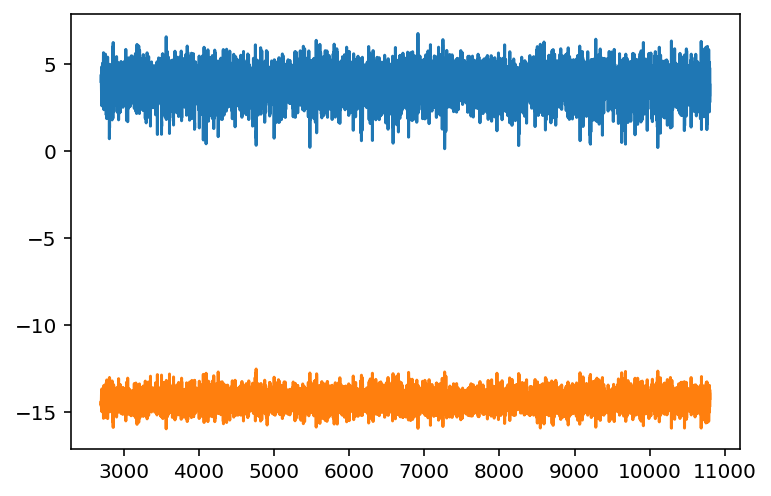

In [18]:
burn_samps = int(0.25*samps.shape[0])

plt.plot(samps[burn_samps:][pars_mcmc[:2]])

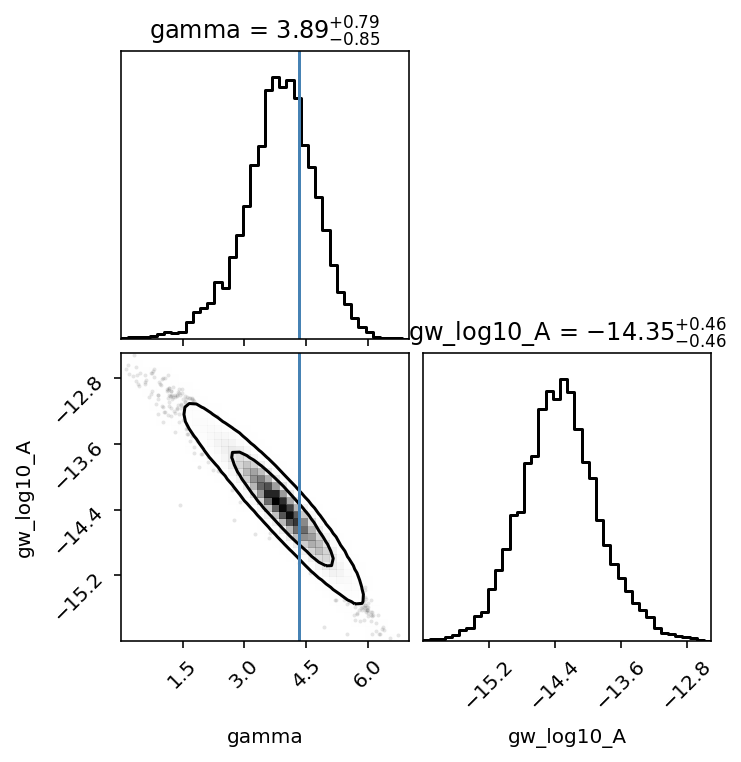

In [20]:
truths = [13/3,None]
corner.corner(samps[pars_mcmc[:2]][burn_samps:], bins=40, range=[(0,7),(-16,-12.5)], levels=[0.68,0.95], smooth=True, smooth1d=False, labels=pars_mcmc[:2], show_titles=True, truths=truths);

In [ ]:
idx = np.where(bin[i] < x < bin[i+1])
pdf = hist[idx]